## Introduction

This notebook aims to perform an in-depth exploratory data analysis before diving into building the recommendation system.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [2]:
export_dir = "./exports/cleaned_data/"
big_matrix_cleaned = pd.read_parquet(export_dir + "big_matrix_cleaned.pq")
caption_category_cleaned = pd.read_parquet(export_dir + "caption_category_cleaned.pq")

## Merging all the data for analysis

In [3]:
all_data_df = big_matrix_cleaned.copy()
all_data_df = all_data_df.merge(caption_category_cleaned, on="video_id", how="left")

## Data Analysis

We chose to run our EDA on the interactions from big_matrix. The reason is that this data will be used to train our model, as intended by the people who crafted the dataset we are using. That is why we run our data analysis on it because it is the data we will manipulate the most for it will be the core of our recommender system.

### Analysis of the time range

In [4]:
start_date = pd.to_datetime(all_data_df["time"].min()).strftime("%Y-%m-%d")
end_date = pd.to_datetime(all_data_df["time"].max()).strftime("%Y-%m-%d")
print(f"Data starts the {start_date} and ends the {end_date}")

Data starts the 2020-06-24 and ends the 2020-09-10


### Analysis of Interaction Repartition

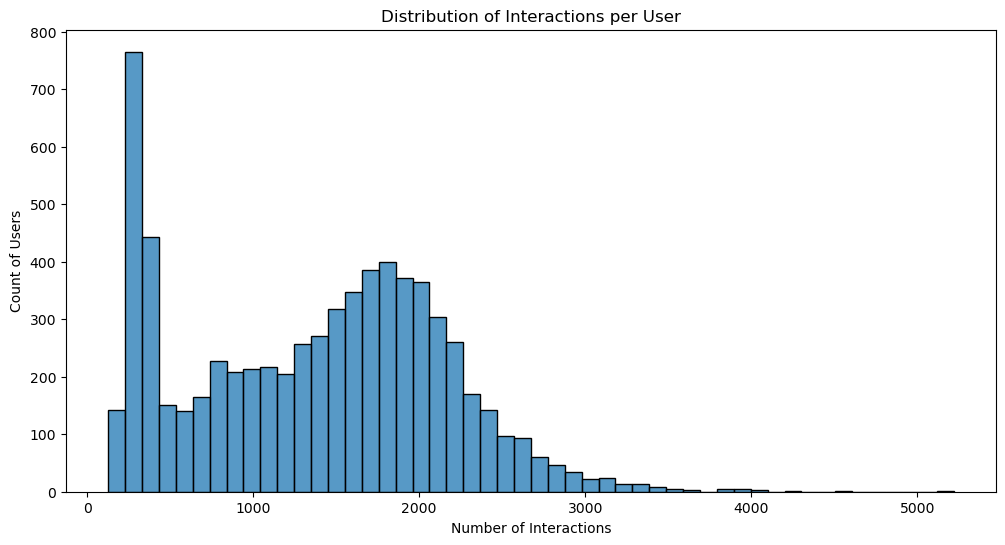

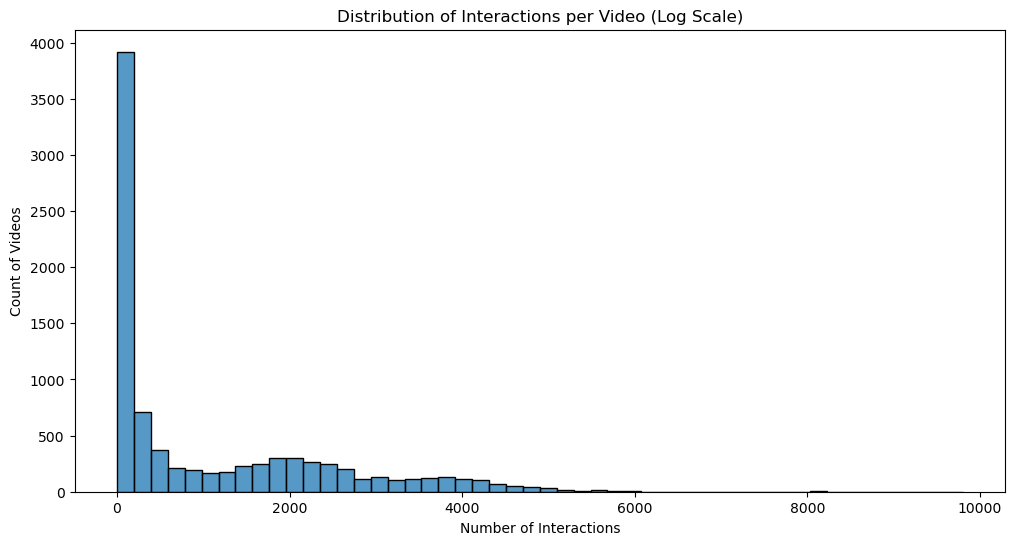

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(data=all_data_df["user_id"].value_counts(), bins=50, log=False)
plt.title("Distribution of Interactions per User")
plt.xlabel("Number of Interactions")
plt.ylabel("Count of Users")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=all_data_df["video_id"].value_counts(), bins=50, log=False)
plt.title("Distribution of Interactions per Video (Log Scale)")
plt.xlabel("Number of Interactions")
plt.ylabel("Count of Videos")
plt.show()

In [6]:
user_counts = all_data_df["user_id"].value_counts()
user_stats = {"mean": user_counts.mean(), "median": user_counts.median(), "std": user_counts.std(), "max": user_counts.max(), "min": user_counts.min()}
video_counts = all_data_df["video_id"].value_counts()
video_stats = {"mean": video_counts.mean(), "median": video_counts.median(), "std": video_counts.std(), "max": video_counts.max(), "min": video_counts.min()}

print("Interactions per User:")
for k, v in user_stats.items():
    print(f"  {k.capitalize()}: {v:.2f}")

print("\nInteractions per Video:")
for k, v in video_stats.items():
    print(f"  {k.capitalize()}: {v:.2f}")

Interactions per User:
  Mean: 1375.04
  Median: 1468.00
  Std: 765.85
  Max: 5219.00
  Min: 127.00

Interactions per Video:
  Mean: 1088.89
  Median: 297.50
  Std: 1367.78
  Max: 9799.00
  Min: 1.00


For our interactions per user:
- Our average activity is pretty high (1375), which suggests that our users tend to be active.
- There is a skewed distribution, as the median (1468) is slightly higher than the mean, indicating a left-skewed distribution.
- There is a wide variability. Indeed, the standard deviation being 765.85 suggests that there is a significant spread in user activitiy levels.
- The least active user has 127 interactions, whereas the most active has 5219. This shows a large gap between some users, backing up the high standard deviation value we got.

For our interactions per video:
- With our mean being 1089 and our median being 297, we can see that the distribution is highly skewed. This large gap suggests a strong right skew, where a small number of videos receive disproportionately high engagement.
- The standard deviation being around 1368 shows there is considerable disparity between popular and unpopular videos, backing up our mean and median values.
- We have a long tail behavior on our plot, which we can understand by our maximum and minimum values, being respectively 9799 and 1. This indicates the presence of a few highly virtal videos alongside a large number of low-engagement ones.

### Analysis of Temporal Activity

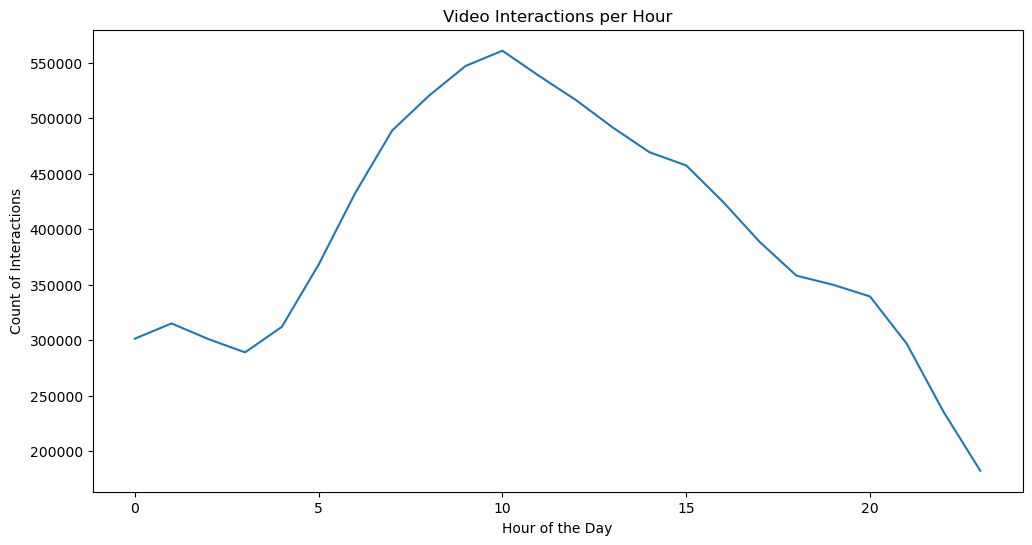

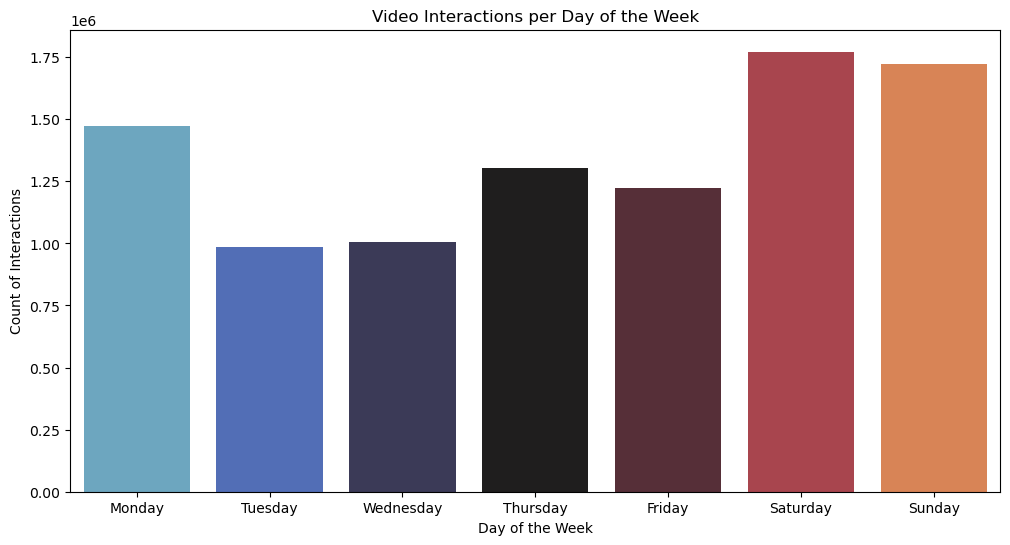

In [7]:
all_data_df["hour"] = all_data_df["time"].dt.hour
all_data_df["weekday"] = all_data_df["time"].dt.dayofweek

to_plot = all_data_df.groupby("hour").size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=to_plot.index, y=to_plot.values)
plt.title("Video Interactions per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Count of Interactions")
plt.show()

to_plot = all_data_df.groupby("weekday").size()
plt.figure(figsize=(12, 6))
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.barplot(x=days, hue=days, legend=False, y=to_plot.values, palette="icefire")
plt.title("Video Interactions per Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Count of Interactions")
plt.show()

For the interactions per day of the week:

Saturday and Sunday are the most active, which is expected for entertainment platforms because people have more free time.
Surprisingly, Monday has higher interactions that most weekdays. This might reflect that people carry some of their weekend content consumption habits into Monday. As the week progresses and routines set in, usage drops until midweek, before rising again as the weekend approaches.

### Analysis of Video Categories

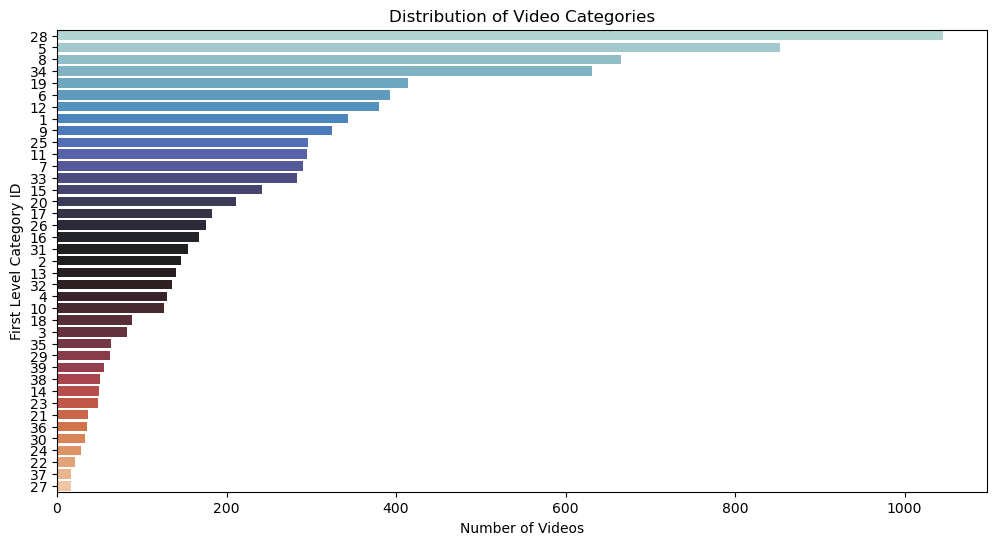

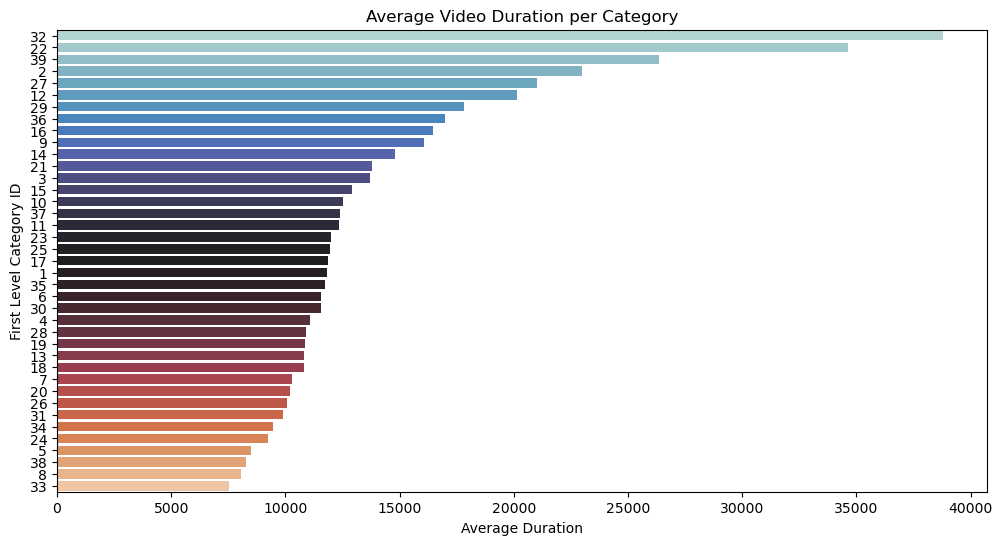

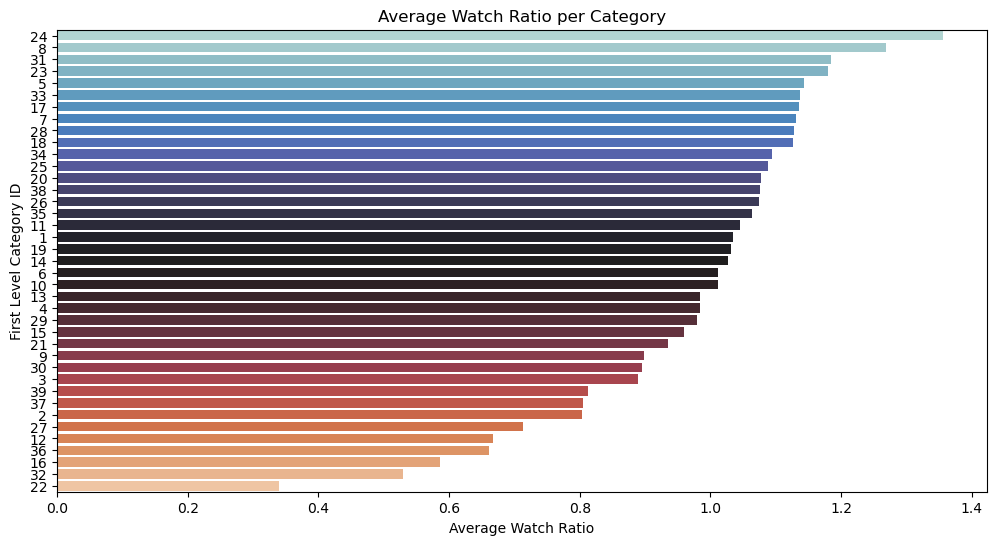

In [8]:
to_plot = all_data_df.drop_duplicates(subset="video_id")[["video_id", "first_level_category_id"]]
plt.figure(figsize=(12, 6))
sns.countplot(data=to_plot, y="first_level_category_id", order=to_plot["first_level_category_id"].value_counts().index, palette="icefire")
plt.title("Distribution of Video Categories")
plt.xlabel("Number of Videos")
plt.ylabel("First Level Category ID")
plt.show()

to_plot = all_data_df.drop_duplicates(subset="video_id").groupby("first_level_category_id")["video_duration"].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=to_plot, y="first_level_category_id", x="video_duration", orient="h", order=to_plot.sort_values("video_duration", ascending=False)["first_level_category_id"], palette="icefire")
plt.title("Average Video Duration per Category")
plt.xlabel("Average Duration")
plt.ylabel("First Level Category ID")
plt.show()

to_plot = all_data_df.groupby('first_level_category_id')['watch_ratio'].agg(['mean', 'count']).sort_values("mean", ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=to_plot, y="first_level_category_id", x="mean", orient="h", order=to_plot.index, palette="icefire")
plt.title("Average Watch Ratio per Category")
plt.xlabel("Average Watch Ratio")
plt.ylabel("First Level Category ID")
plt.show()

These plots show us there are clear trends between video categories. Some are way more represented in the overall video pool, some tend to be way longer than in the other categories. Moreover, we can see that most video categories tend to have an average watch ratio around 1, with the exception of some outliers.

### Analysis on watch ratio

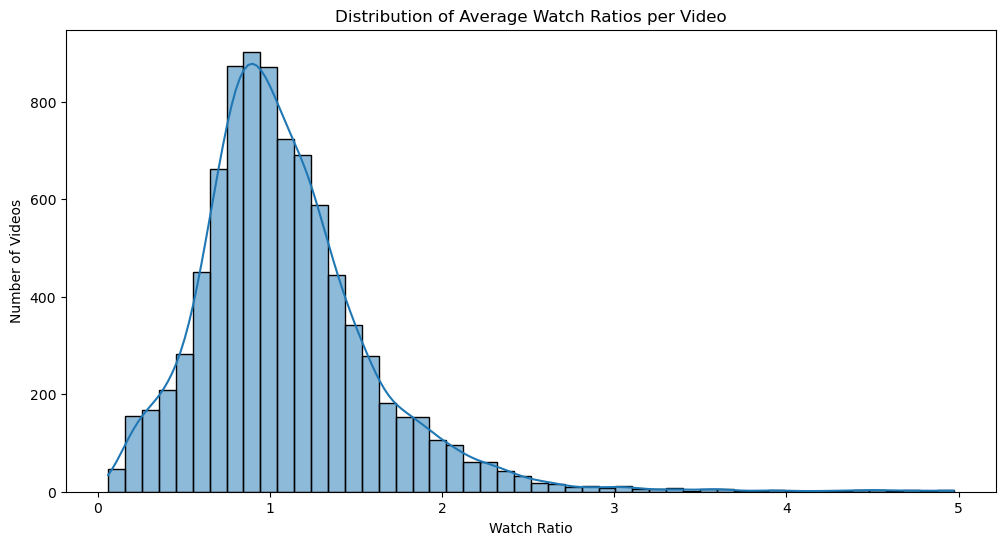

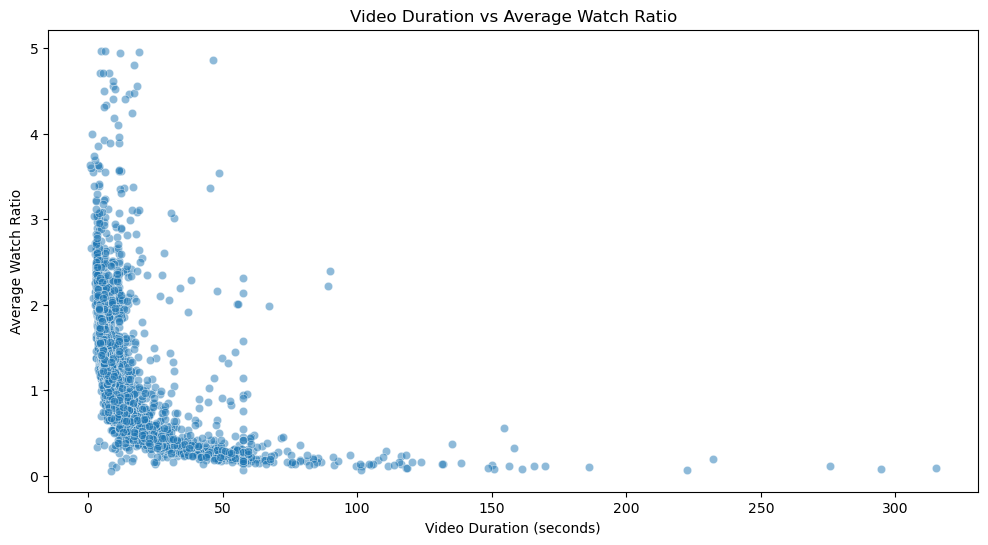

In [9]:
to_plot = all_data_df.groupby("video_id")["watch_ratio"].mean()
plt.figure(figsize=(12, 6))
sns.histplot(data=to_plot, bins=50, kde=True)
plt.title("Distribution of Average Watch Ratios per Video")
plt.xlabel("Watch Ratio")
plt.ylabel("Number of Videos")
plt.show()

to_plot = all_data_df.groupby("video_id").agg({"video_duration": "first", "watch_ratio": "mean"}).reset_index()
to_plot["video_duration"] = to_plot["video_duration"] / 1000
plt.figure(figsize=(12, 6))
sns.scatterplot(data=to_plot, x="video_duration", y="watch_ratio", alpha=0.5)
plt.title("Video Duration vs Average Watch Ratio")
plt.xlabel("Video Duration (seconds)")
plt.ylabel("Average Watch Ratio")
plt.show()

These plots reveal two key insights:
- The watch ratio follows a roughly Gaussian distribution, centered around 1, indicating that users often watch videos close to their full length.
- There is a negative correlation between video length and watch ratio. In general, the longer the video, the lower the watch ratio tends to be.

These observations are valuable for understanding user engagement patterns in the dataset we are manipulating.